In [2]:
library(Signac)
library(Seurat)
library(rtracklayer)
library(GenomicRanges)
library(EnsDb.Mmusculus.v79)
library(viridis)
library(RColorBrewer)
library(ggplot2)
library(UpSetR)
library(reshape2)

source('../scripts/plotting.R')

In [14]:
# filtered snATAC output from Signac
get_filt_tss_atac <- function() {
    load('../processing/ends/mb_mt_atac_tss_10pct_filt.rda')
    obj = mb_mt_atac_tss
    return(obj)
}

# bulk TESs
get_bulk_tes_beds <- function() {
    bulk_tes_80 = read.delim('../processing/ends/bulk_tes_80_combo_gencode_polyA.bed', stringsAsFactors = F, header = F)
    bulk_tes_80_ends = read.delim('../processing/ends/bulk_tes_80.sort.bed', stringsAsFactors = F, header = F)
    return(list(bulk_tes_80, bulk_tes_80_ends))
}

# sc TESs
get_sc_tes_beds <- function() {
    sc_tes_80 = read.delim('../processing/ends/sc_tes_80_combo_gencode_polyA.bed', stringsAsFactors = F, header = F)
    sc_tes_80_ends = read.delim('../processing/ends/sc_tes_80.sort.bed', stringsAsFactors = F, header = F)
    return(list(sc_tes_80, sc_tes_80_ends))
}

# bed files for TSSs 
get_tss_beds <- function() {
    bulk_tss_5 = read.delim('../processing/ends/bulk_tss_5_combo_gencode_prmenhP_cage_snatac18.bed', stringsAsFactors = F, header = F)
    bulk_tss_5_ends = read.delim('../processing/ends/bulk_tss_5.sort.bed', stringsAsFactors = F, header = F)
    return(list(bulk_tss_5, bulk_tss_5_ends))
}

# get TSS + read annot for long-Split-seq data
get_tss_annot <- function() {
    tss_annot = as.data.frame(read.delim('../processing/ends/sc_tss_10.sort.bed', header = F))
    return(tss_annot)
}

### Panel S5A

pdf 
  2

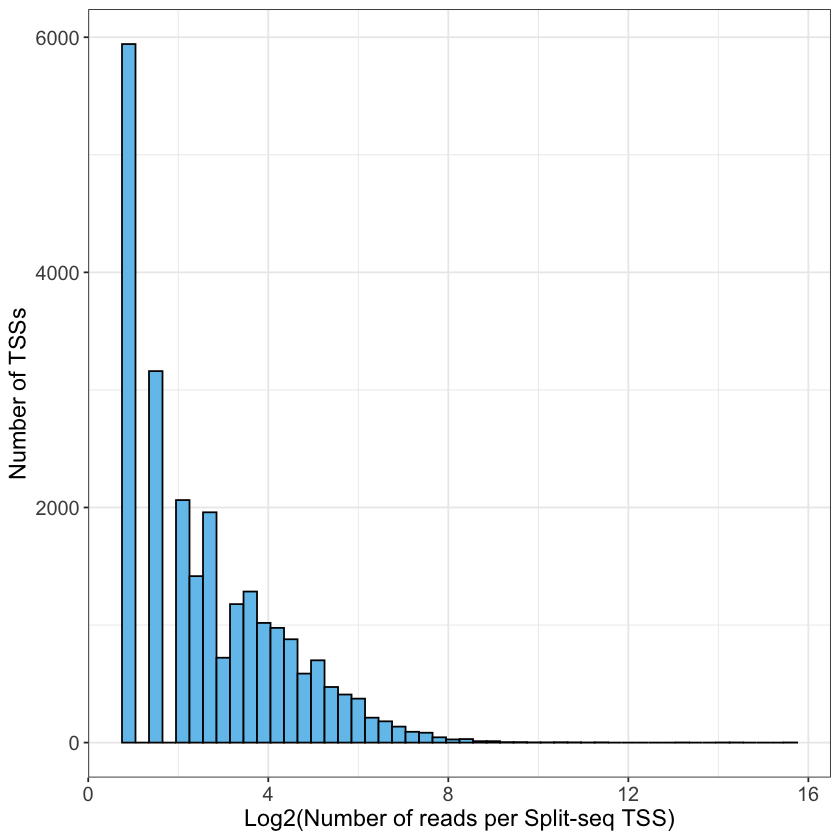

In [4]:
tss_annot = get_tss_annot()
tss_annot$n_reads = as.numeric(sapply(strsplit(sapply(strsplit(as.character(tss_annot$V4), "ccs_"), "[[", 2), "_"), "[[", 2))

fname = "figures/histogram.pdf"
pdf(file = fname,
    width = 8,
    height = 8)
p = ggplot(tss_annot, aes(x=log2(n_reads)))  + 
  geom_histogram(colour="black", fill="#74C4ED",binwidth=0.3)+theme_bw()+
  theme(legend.position = "none",axis.text=element_text(size=12),
        axis.title=element_text(size=14)) +xlab("Log2(Number of reads per Split-seq TSS)")+ylab("Number of TSSs")
p
dev.off()
p

### Panel S5C

Using combo_name as value column: use value.var to override.



pdf 
  2

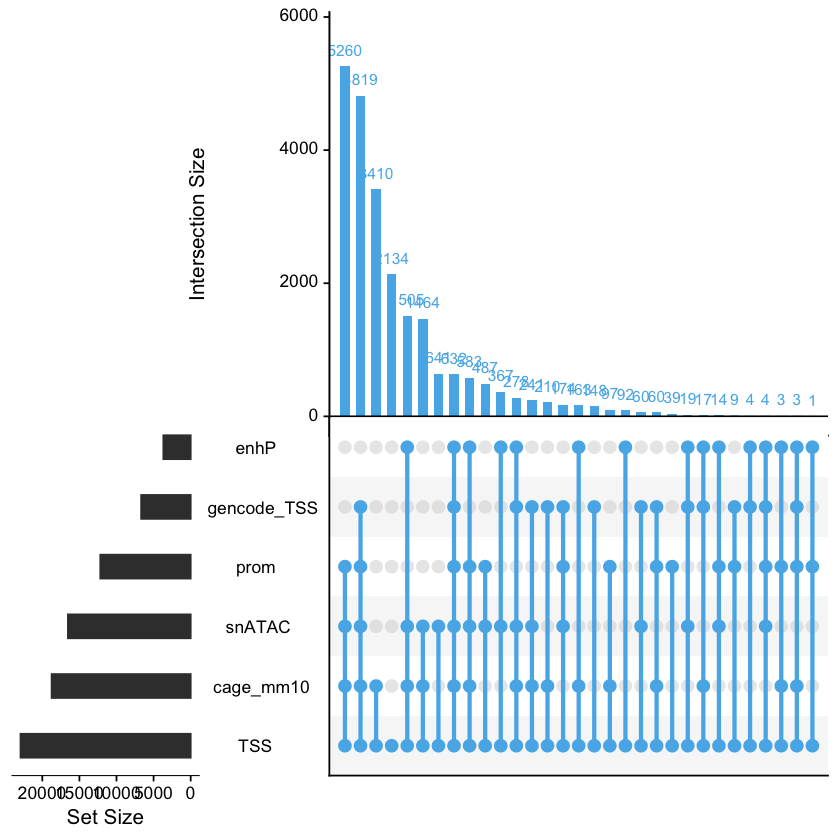

In [7]:
objs = get_tss_beds()
bulk_tss_5 = objs[[1]]
bulk_tss_5_ends = objs[[2]]

colnames(bulk_tss_5) = c("end_chr","end_start","ends_stop","end_readID",
                        "end_score","end_strand","combo_chr","combo_start",
                        "combo_stop","combo_name","combo_score","combo_strand")
colnames(bulk_tss_5_ends) = c("end_chr","end_start","ends_stop","end_readID",
                   "end_score","end_strand")

bulk_tss_5$end_id_nreads = sapply(strsplit(as.character(bulk_tss_5$end_readID), "ccs_"), "[[", 2)
bulk_tss_5_ends$end_id_nreads = sapply(strsplit(as.character(bulk_tss_5_ends$end_readID), "ccs_"), "[[", 2)

tss_missing = bulk_tss_5_ends$end_id_nreads[which((bulk_tss_5_ends$end_id_nreads %in% bulk_tss_5$end_id_nreads) == FALSE)]
tss_missing = as.data.frame(tss_missing)
tss_missing$cage_mm10 = rep(0, length(tss_missing))
tss_missing$enhP = rep(0, dim(tss_missing)[1])
tss_missing$gencode_TSS = rep(0, dim(tss_missing)[1])
tss_missing$prom = rep(0, dim(tss_missing)[1])
tss_missing$snATAC = rep(0, dim(tss_missing)[1])

bulk_tss_5_smol = bulk_tss_5[,c("end_id_nreads","combo_name")]
bulk_tss_5_table = dcast(bulk_tss_5_smol,end_id_nreads~combo_name,fun.aggregate = function(x){as.integer(length(x) > 0)})
colnames(tss_missing) = colnames(bulk_tss_5_table)
bulk_tss_5_table = rbind(bulk_tss_5_table, tss_missing)
bulk_tss_5_table$TSS = rep(1,dim(bulk_tss_5_table)[1])

fname = "figures/bulk_tss_5pct_upset.pdf"
pdf(file = fname,
    width = 10,
    height = 4)
p = upset(
  bulk_tss_5_table,
  nsets = 7,
  nintersects = NA,
  order.by = "freq",
  line.size = 1.2,
  point.size = 3.5,
  text.scale = 1.5,
  mb.ratio = c(0.5, 0.5),
  main.bar.color = "#56B4E9",
  matrix.color="#56B4E9"
)
p
dev.off()
p

### Panel S5E

Using combo_name as value column: use value.var to override.



pdf 
  2

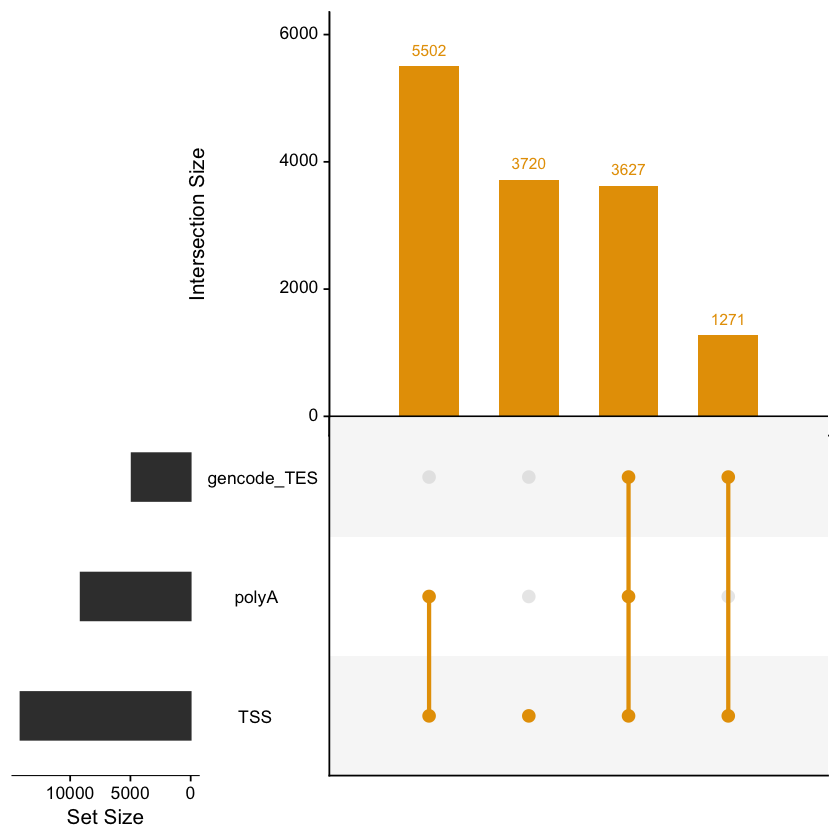

In [17]:
obj = get_bulk_tes_beds()
bulk_tes_80 = obj[[1]]
bulk_tes_80_ends = obj[[2]]

colnames(bulk_tes_80) = c("end_chr","end_start","ends_stop","end_readID",
                         "end_score","end_strand","combo_chr","combo_start",
                         "combo_stop","combo_name","combo_score","combo_strand")
colnames(bulk_tes_80_ends) = c("end_chr","end_start","ends_stop","end_readID",
                              "end_score","end_strand")

bulk_tes_80$end_id_nreads = sapply(strsplit(as.character(bulk_tes_80$end_readID), "ccs_"), "[[", 2)
bulk_tes_80_ends$end_id_nreads = sapply(strsplit(as.character(bulk_tes_80_ends$end_readID), "ccs_"), "[[", 2)

tss_missing = bulk_tes_80_ends$end_id_nreads[which((bulk_tes_80_ends$end_id_nreads %in% bulk_tes_80$end_id_nreads) == FALSE)]
tss_missing = as.data.frame(tss_missing)
tss_missing$gencode_TES = rep(0, length(tss_missing))
tss_missing$polyA = rep(0, dim(tss_missing)[1])

bulk_tes_80_smol = bulk_tes_80[,c("end_id_nreads","combo_name")]
bulk_tes_80_table = dcast(bulk_tes_80_smol,end_id_nreads~combo_name,fun.aggregate = function(x){as.integer(length(x) > 0)})
colnames(tss_missing) = colnames(bulk_tes_80_table)
bulk_tes_80_table = rbind(bulk_tes_80_table, tss_missing)
bulk_tes_80_table$TSS = rep(1,dim(bulk_tes_80_table)[1])

fname = "figures/bulk_tes_80pct_upset.pdf"
pdf(file = fname,
    width = 4.5,
    height = 4)
p = upset(
  bulk_tes_80_table,
  nsets = 7,
  nintersects = NA,
  order.by = "freq",
  line.size = 1.2,
  point.size = 3.5,
  text.scale = 1.5,
  mb.ratio = c(0.5, 0.5),
  main.bar.color = "#E69F00",
  matrix.color="#E69F00"
)
p
dev.off()
p

### Panel S5G

Using combo_name as value column: use value.var to override.



pdf 
  2

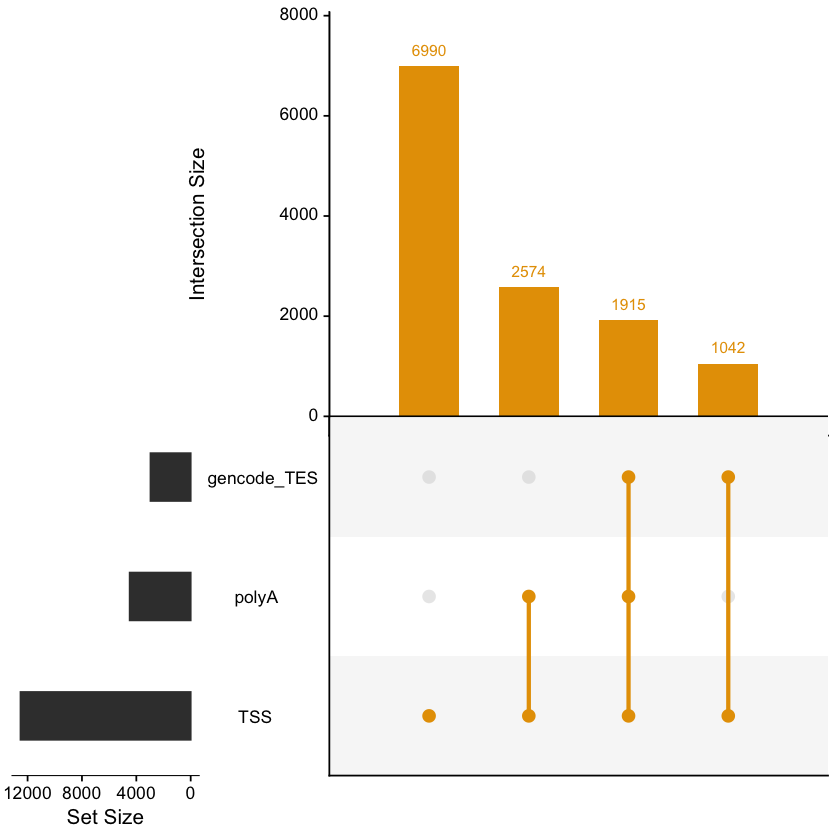

In [20]:
obj = get_sc_tes_beds()
sc_tes_80 = obj[[1]]
sc_tes_80_ends = obj[[2]]

colnames(sc_tes_80) = c("end_chr","end_start","ends_stop","end_readID",
                          "end_score","end_strand","combo_chr","combo_start",
                          "combo_stop","combo_name","combo_score","combo_strand")
colnames(sc_tes_80_ends) = c("end_chr","end_start","ends_stop","end_readID",
                               "end_score","end_strand")

sc_tes_80$end_id_nreads = sapply(strsplit(as.character(sc_tes_80$end_readID), "ccs_"), "[[", 2)
sc_tes_80_ends$end_id_nreads = sapply(strsplit(as.character(sc_tes_80_ends$end_readID), "ccs_"), "[[", 2)

tss_missing = sc_tes_80_ends$end_id_nreads[which((sc_tes_80_ends$end_id_nreads %in% sc_tes_80$end_id_nreads) == FALSE)]
tss_missing = as.data.frame(tss_missing)
tss_missing$gencode_TES = rep(0, length(tss_missing))
tss_missing$polyA = rep(0, dim(tss_missing)[1])

sc_tes_80_smol = sc_tes_80[,c("end_id_nreads","combo_name")]
sc_tes_80_table = dcast(sc_tes_80_smol,end_id_nreads~combo_name,fun.aggregate = function(x){as.integer(length(x) > 0)})
colnames(tss_missing) = colnames(sc_tes_80_table)
sc_tes_80_table = rbind(sc_tes_80_table, tss_missing)
sc_tes_80_table$TSS = rep(1,dim(sc_tes_80_table)[1])

fname = "figures/sc_tes_80pct_upset.pdf"
pdf(file = fname,
    width = 4.5,
    height = 4)
p = upset(
  sc_tes_80_table,
  nsets = 7,
  nintersects = NA,
  order.by = "freq",
  line.size = 1.2,
  point.size = 3.5,
  text.scale = 1.5,
  mb.ratio = c(0.5, 0.5),
  main.bar.color = "#E69F00",
  matrix.color="#E69F00"
)
p
dev.off()
p

### Panel S5I

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



pdf 
  2

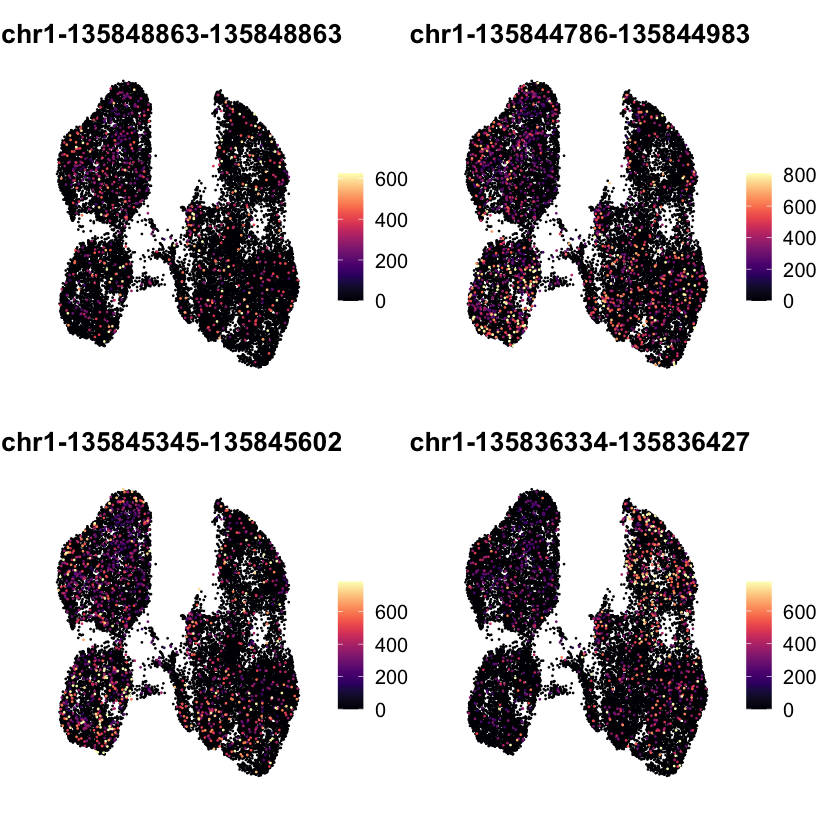

In [12]:
mb_mt_atac_tss = get_filt_tss_atac()

DefaultAssay(mb_mt_atac_tss) <- 'TSS'

tsss = c("chr1-135848863-135848863", #1
         "chr1-135844786-135844983", #2
         "chr1-135845345-135845602", #3
         "chr1-135836334-135836427") #4

fname = "figures/snatac_tnnt2_umaps.pdf"
pdf(file = fname,
    width = 9.6,
    height = 2.5)
p = FeaturePlot(
  object = mb_mt_atac_tss,
  features = tsss,
  pt.size = 0.1,label = F,
  max.cutoff = 'q95',
  order=T, ncol = 2
)  & NoAxes() & scale_colour_gradientn(colours = magma(21)) #& NoLegend() 
p
dev.off()
p